In [2]:
#This is the agent file for utilizing both the game file and training methods to train our snake playing model
# The steps this function takes:
# Step 1:  Get the current game state
# Step 2:  Take an action (use our machine learning model to predict the next action)
# Step 3:  Check reward, game over status, and score as result of the predicted action
# Step 4:  Get the new game state following the action
# Step 5:  Remember results of taking the above action
# Step 6:  Use results to train the model, hopefully improving future selected actions

import torch
import random
import numpy as np
from collections import deque
from snake_game_AI import SnakeGameAI, Direction, Point
from model import Linear_QNet, QTrainer
import matplotlib.pyplot as plt
from IPython import display
plt.ion()

#Initialize variables
MAX_MEMORY = 100000
BATCH_SIZE = 1000
LR = 0.0005 #Learning rate

In [3]:
class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 #Randomness
        self.gamma = 0.9 #Discount rate
        self.memory = deque(maxlen=MAX_MEMORY) #Popleft()
        self.model = Linear_QNet(11, 256, 3) #11 input parameters, 256 hidden layer size, output 3 (straight, left, or right)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game): #Get current state of the game
        #Initialize variables
        head = game.snake[0] #Head location
        #Create four points around head (20 is hardcoded as game object sizes)
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)
        
        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        #Get state:  List of 11 total values, all either 1 (if true) or 0 (if false)
        # First three: If there's danger straight/right/left
        # Next four:  Movement direction (l/r/u/d)
        # Last four:  Food location (l/r/u/d)
        state = [
            #Danger straight
            (dir_r and game.is_collision(point_r)) or 
            (dir_l and game.is_collision(point_l)) or 
            (dir_u and game.is_collision(point_u)) or 
            (dir_d and game.is_collision(point_d)),

            #Danger right
            (dir_u and game.is_collision(point_r)) or 
            (dir_d and game.is_collision(point_l)) or 
            (dir_l and game.is_collision(point_u)) or 
            (dir_r and game.is_collision(point_d)),

            #Danger left
            (dir_d and game.is_collision(point_r)) or 
            (dir_u and game.is_collision(point_l)) or 
            (dir_r and game.is_collision(point_u)) or 
            (dir_l and game.is_collision(point_d)),
            
            #Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,
            
            #Food location 
            game.food.x < game.head.x,  #Food left
            game.food.x > game.head.x,  #Food right
            game.food.y < game.head.y,  #Food up
            game.food.y > game.head.y  #Food down
            ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):  #Remember game values
        self.memory.append((state, action, reward, next_state, done)) #Pop left if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE: #If number of remembered steps larger than allowed batch size
            mini_sample = random.sample(self.memory, BATCH_SIZE) #Use random sample of remembered moves
        else: #If number of remembered steps is smaller than batch size, use them all
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample) #Grab values from sub-sample
        self.trainer.train_step(states, actions, rewards, next_states, dones) #Plural b/c we have multiple values

    def train_short_memory(self, state, action, reward, next_state, done):  #Only train single latest step
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        #Random moves: tradeoff exploration / exploitation, using epsilon parameter defined above
        # Basic idea:  We want some random moves to improve learning, but we also want to lean more on
        # our model's findings as the training goes on, so we need to balance these needs.
        self.epsilon = 80 - (self.n_games)*0.75 #More games -> smaller epsilon -> less random moves
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2) #Give random move of 0,1,2
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

In [4]:
#Helper plotting function to track model performance
def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1)

In [5]:
#Train model performance
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0 #Starting score of 0
    record = 0 #Best score at start is 0
    agent = Agent()
    game = SnakeGameAI()
    while True:
        #Get original game state
        state_old = agent.get_state(game)

        #Get movement input
        final_move = agent.get_action(state_old)

        #Perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        #Train short memory (single step)
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        #Store previous information in memory
        agent.remember(state_old, final_move, reward, state_new, done)

        if done: #If game over
            #Train long memory (all previous moves), plot result
            game.reset()
            agent.n_games += 1
            agent.train_long_memory()

            #Check if new high score
            if score > record:
                record = score
                agent.model.save() #Save the model producing the new high score

            #Print results
            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)

<Figure size 640x480 with 0 Axes>

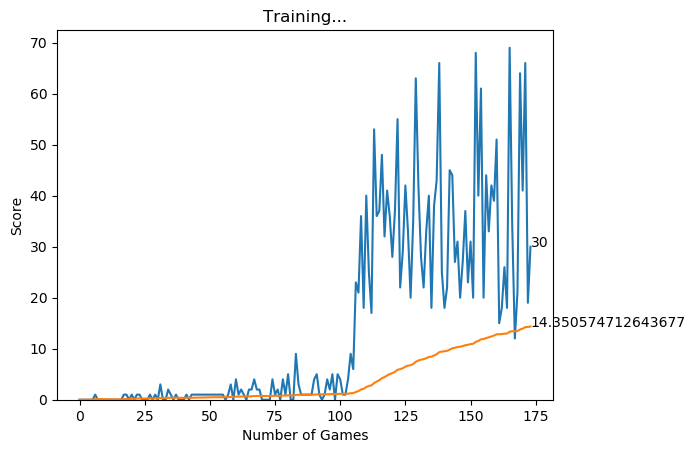

KeyboardInterrupt: 

In [6]:
#Finally, train the model
train()